Queen's Campus Campus Pathfinding
Reinforcment Learning agent who uses Q-Learning to find the shortest path between two points on Campus

Reference Materials:

[Overpass API/Overpass QL](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL): API and Query Language for accessing Open Street Maps data.

[Overpass Turbo](https://overpass-turbo.eu/): Website to help build and visualize Overpass API calls.

[Networkx](https://networkx.org/documentation/networkx-2.4/reference/classes/generated/networkx.Graph.neighbors.html): To manage OSM's node and way data and connections between these objects.

[OSM Parser](https://github.com/Tofull/networkx-osm/blob/master/OSMParser.py): To transform OSM data from the API into a networkx graph


# Graph Implementation:





## Data Import and Preprocessing

In [1]:
import copy
import urllib.request
import xml.sax
from math import radians, cos, sin, asin, sqrt
from pathlib import Path

!pip install networkx
import networkx


def haversine_distance(lon1, lat1, lon2, lat2, unit_m=True):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    default unit : km
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of the Earth in kilometers. Use 3956 for miles
    if unit_m:
        r *= 1000
    return c * r


def download_osm(left, bottom, right, top, proxy=False, cache=False, cacheTempDir="", verbose=True):
    """ Return a filehandle to the downloaded data from osm api."""
    if cache:
        # cached tile filename
        cachedTileFilename = "osm_map_{:.8f}_{:.8f}_{:.8f}_{:.8f}.map".format(left, bottom, right, top)

        if verbose:
            print("Cached tile filename :", cachedTileFilename)

        cacheTempDir = Path(cacheTempDir)
        cacheTempDir.mkdir(parents=True, exist_ok=True)  # Create cache path if not exists

        osmFile = Path(cacheTempDir / cachedTileFilename).resolve()  # Replace the relative cache folder path to absolute path

        if osmFile.is_file():
            # download from the cache folder
            if verbose:
                print("Tile loaded from the cache folder.")

            with open(osmFile, mode='r') as f:
                content = f.read()
            return content

    if proxy:
        # configure the urllib request with the proxy
        proxy_handler = urllib.request.ProxyHandler({'https': 'https://' + proxyHost + ":" + proxyPort, 'http': 'http://' + proxyHost + ":" + proxyPort})
        opener = urllib.request.build_opener(proxy_handler)
        urllib.request.install_opener(opener)

    request = "http://api.openstreetmap.org/api/0.6/map?bbox=%f,%f,%f,%f" % (left, bottom, right, top)

    if verbose:
        print("Download the tile from osm web api ... in progress")
        print("Request :", request)

    fp = urllib.request.urlopen(request)
    content = fp.read().decode('utf-8')

    if verbose:
        print("OSM Tile downloaded")

    if cache:
        if verbose:
            print("Write osm tile in the cache")

        with open(osmFile, 'w') as f:
            f.write(content)

        if osmFile.is_file():
            if verbose:
                print("OSM tile written in the cache")

    return content


def read_osm(osm_xml_data, is_xml_string=True, only_roads=True):
    """Read graph in OSM format from file specified by name or by stream object.
    Parameters
    ----------
    filename_or_stream : filename or stream object
    Returns
    -------
    G : Graph
    Examples
    --------
    >>> G=nx.read_osm(nx.download_osm(-122.33,47.60,-122.31,47.61))
    >>> import matplotlib.pyplot as plt
    >>> plt.plot([G.node[n]['lat']for n in G], [G.node[n]['lon'] for n in G], 'o', color='k')
    >>> plt.show()
    """
    osm = OSM(osm_xml_data, is_xml_string=is_xml_string)
    G = networkx.DiGraph()

    ## Add ways
    for w in osm.ways.values():
        if only_roads and 'highway' not in w.tags:
            continue

        if ('oneway' in w.tags):
            if (w.tags['oneway'] == 'yes'):
                # ONLY ONE DIRECTION
                networkx.add_path(G, w.nds, id=w.id)
            else:
                # BOTH DIRECTION
                networkx.add_path(G, w.nds, id=w.id)
                networkx.add_path(G, w.nds[::-1], id=w.id)
        else:
            # BOTH DIRECTION
            networkx.add_path(G, w.nds, id=w.id)
            networkx.add_path(G, w.nds[::-1], id=w.id)

    # Complete the used nodes' information
    coordinates_map = {}
    for n_id in G.nodes():
        n = osm.nodes[n_id]
        G.nodes[n_id]['lat'] = n.lat
        G.nodes[n_id]['lon'] = n.lon
        G.nodes[n_id]['id'] = n.id
        coordinates_map[n_id] = (n.lon, n.lat)

    # Estimate the length of each way
    for u, v, d in G.edges(data=True):
        distance = haversine_distance(G.nodes[u]['lon'], G.nodes[u]['lat'], G.nodes[v]['lon'], G.nodes[v]['lat'], unit_m=True)  # Give a realistic distance estimation (neither EPSG nor projection nor reference system are specified)

        G.add_weighted_edges_from([(u, v, distance)], weight='havlen')

    G = networkx.relabel_nodes(G, coordinates_map)
    return G


class Node(object):
    def __init__(self, id, lon, lat):
        self.id = id
        self.lon = lon
        self.lat = lat
        self.tags = {}

    def __str__(self):
        return "Node (id : %s) lon : %s, lat : %s "%(self.id, self.lon, self.lat)


class Way(object):
    def __init__(self, id, osm):
        self.osm = osm
        self.id = id
        self.nds = []
        self.tags = {}

    def split(self, dividers):
        # slice the node-array using this nifty recursive function
        def slice_array(ar, dividers):
            for i in range(1,len(ar)-1):
                if dividers[ar[i]]>1:
                    left = ar[:i+1]
                    right = ar[i:]

                    rightsliced = slice_array(right, dividers)

                    return [left]+rightsliced
            return [ar]

        slices = slice_array(self.nds, dividers)

        # create a way object for each node-array slice
        ret = []
        i = 0
        for slice in slices:
            littleway = copy.copy(self)
            littleway.id += "-%d" % i
            littleway.nds = slice
            ret.append(littleway)
            i += 1

        return ret


class OSM(object):
    def __init__(self, osm_xml_data, is_xml_string=True):
        """ File can be either a filename or stream/file object.
        set `is_xml_string=False` if osm_xml_data is a filename or a file stream.
        """
        nodes = {}
        ways = {}

        superself = self

        class OSMHandler(xml.sax.ContentHandler):
            @classmethod
            def setDocumentLocator(self, loc):
                pass

            @classmethod
            def startDocument(self):
                pass

            @classmethod
            def endDocument(self):
                pass

            @classmethod
            def startElement(self, name, attrs):
                if name == 'node':
                    self.currElem = Node(attrs['id'], float(attrs['lon']), float(attrs['lat']))
                elif name == 'way':
                    self.currElem = Way(attrs['id'], superself)
                elif name == 'tag':
                    self.currElem.tags[attrs['k']] = attrs['v']
                elif name == 'nd':
                    self.currElem.nds.append(attrs['ref'])

            @classmethod
            def endElement(self, name):
                if name == 'node':
                    nodes[self.currElem.id] = self.currElem
                elif name == 'way':
                    ways[self.currElem.id] = self.currElem

            @classmethod
            def characters(self, chars):
                pass

        if is_xml_string:
            xml.sax.parseString(osm_xml_data, OSMHandler)
        else:
            with open(osm_xml_data, mode='r') as f:
                xml.sax.parse(f, OSMHandler)

        self.nodes = nodes
        self.ways = ways

        # count times each node is used
        node_histogram = dict.fromkeys(self.nodes.keys(), 0)
        for way in self.ways.values():
            if len(way.nds) < 2:  # if a way has only one node, delete it out of the osm collection
                del self.ways[way.id]
            else:
                for node in way.nds:
                    node_histogram[node] += 1

        # use that histogram to split all ways, replacing the member set of ways
        new_ways = {}
        for id, way in self.ways.items():
            split_ways = way.split(node_histogram)
            for split_way in split_ways:
                new_ways[split_way.id] = split_way
        self.ways = new_ways


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Create and parse Graph from osm data

Download the tile from osm web api ... in progress
Request : http://api.openstreetmap.org/api/0.6/map?bbox=-76.501706,44.222450,-76.490355,44.229823
OSM Tile downloaded
[(-76.4905204, 44.2249349), (-76.4906166, 44.2249251), (-76.4908169, 44.2249044), (-76.4910503, 44.2248791), (-76.4916043, 44.2247953), (-76.4920893, 44.2247281), (-76.4925185, 44.2246686), (-76.4933756, 44.2245498), (-76.4937009, 44.2245047), (-76.4941718, 44.2244394), (-76.4945764, 44.2243834), (-76.4949564, 44.2243307), (-76.4950209, 44.2243218), (-76.4981811, 44.2226623), (-76.4981973, 44.2227323), (-76.4982021, 44.2227555), (-76.4982693, 44.2232467), (-76.4983231, 44.2237133), (-76.4983266, 44.2237433), (-76.4983337, 44.2238048), (-76.4828884, 44.226855), (-76.4829824, 44.2268996), (-76.4830129, 44.226914), (-76.4831565, 44.2269821), (-76.4835019, 44.2271458), (-76.4838035, 44.2272888), (-76.4838653, 44.2273181), (-76.4839521, 44.2273593), (-76.4840286, 44.2273956), (-76.4840597, 44.2274103), (-76.4851312, 44.22791

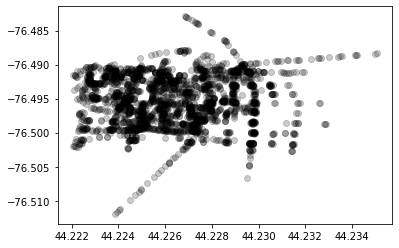

<class 'networkx.classes.graph.Graph'>


In [2]:
from matplotlib import pyplot as plt

#Download OSM data for queen's "bounding box"
d = download_osm(left=-76.5017059541, bottom=44.2224495448, right=-76.4903552918, top=44.2298231916)
G = read_osm(d,only_roads=True)

G = G.to_undirected() #Agent can move both ways
print(G.nodes)

plt.plot([G.nodes[n]['lat']for n in G], [G.nodes[n]['lon'] for n in G], 'o', color='k', alpha=0.2)
plt.show()

print(type(G))



Nodes are (lon,lat) tuples of coordinates

In [3]:
NV = G.nodes()
i = 0
# Some sample coordinates from the graph
for n in NV:
  i+=1
  if i < 5:
    print(n)
    print(type(n))

(-76.4905204, 44.2249349)
<class 'tuple'>
(-76.4906166, 44.2249251)
<class 'tuple'>
(-76.4908169, 44.2249044)
<class 'tuple'>
(-76.4910503, 44.2248791)
<class 'tuple'>


### Enviroment

In [4]:
class CWorld:
  def __init__(self, data: networkx.classes.digraph.DiGraph,start: tuple,terminal: tuple):
    self._terminal = terminal
    self._start = start
    self.data = data 

  def get_adjacent(self, node: tuple):
    # Get adjacent nodes from original node
    #return: nodes (should be tuple of coordinates)
    return self.data.neighbors(node)

  def get_reward(self, nodeStart: tuple, nodeEnd: tuple):
    #Get reward (distance, in meters between two nodes) - Haversine formula
      if nodeStart == self._terminal:
        return 0
      # return - self.data.get_edge_data(nodeStart,nodeEnd)["havlen"] #reward is negative distance
      return - round(haversine_distance(nodeStart[0], nodeStart[1], nodeEnd[0], nodeEnd[1]),3)

## Q-Learning

In [5]:
import numpy as np

class Q_learning:

  def __init__(self, world: CWorld, alpha, gamma, e, max_eps=500, max_steps=500): 
    self.q = {}
    self.alpha = alpha #(0,1)
    self.gamma = gamma 
    self.e = e # e > 0
    self.max_eps= max_eps
    self.world = world
    self.max_steps = max_steps
    self.episodes_array_stats = np.zeros(max_eps,)
    self.steps_array_stats = np.zeros(max_eps,)

    #Q-Table set up
    #States are nodes,
    #Actions are edges between these nodes
    for node in world.data.nodes():
        self.q[node] = {}
        
        if node != self.world._terminal:
          for adjNode in self.world.get_adjacent(node): 
            self.q[node][adjNode] = 10

        else:
          #Terminal
          for adjNode in self.world.get_adjacent(node):
              self.q[node][adjNode] = 0

  def get_next_state(self,node: tuple,epsilon=True,drop_state=None):
      eps = self.e
      if not epsilon:
        eps = 0

      mx_nxt_reward = float('-inf')
      action = None

      rc = np.random.choice(['exploit','explore'], p=[1-eps, eps])

      if rc == 'exploit':
          #parse
          for s_prime in self.q[node]:
            
            if drop_state is not None:
                if s_prime == drop_state and len(self.q[node]) > 1:
                    continue
            
            nxt_reward = self.q[node][s_prime]
  
            if nxt_reward >= mx_nxt_reward:
                action = s_prime
                mx_nxt_reward = nxt_reward

      elif rc == "explore":
          action_idx = np.random.choice(len(list(self.q[node])))
          action = list(self.q[node])[action_idx]

      return action
  
  def train(self):
    total_goal = 0 # show how many times agent has hit the goal
    cur_steps = 0 # Current total steps
    for i in range(0, self.max_eps):
        s = self.world._start
        cur2 = 0 #Current live steps
        skip = False
        
        while s != self.world._terminal and cur2 < self.max_steps:
            
            cur2+=1
            cur_steps = cur_steps+1

            #Choose a from S using policy derived from q
            a = self.get_next_state(s)

            # Take action A, observe S', R
            s_prime = a
            r = (self.world.get_reward(s,s_prime))

            qsa = self.q[s][a]
            maxa = self.get_next_state(s_prime,epsilon=False)#greedy
            self.q[s][a] = qsa + self.alpha*(r + self.gamma * (self.q[s_prime][maxa]) - qsa )
            #print(str(total_goal)+": Current location is: "+str(s))
            #print("Moving to location: "+str(s_prime)+" with weight"+str(r))
            s = s_prime

            #For performance tracking
            if s == self.world._terminal:
              print("===========Reached end===================================")
              total_goal+=1
              print(total_goal) 
              print("Moving to location: "+str(s_prime)+" with weight"+str(r))
              print("Steps taken:" + str(cur2))
            if cur2 >= self.max_steps:
              print("=====HIT MAX STEPS=========================================")
              skip = True
        #For performance tracking
        if not skip: 
          self.episodes_array_stats[i] = i
          self.steps_array_stats[i] = cur_steps
        else:
          if i == 0:
            continue
          self.episodes_array_stats[i] = i
          self.steps_array_stats[i] = self.steps_array_stats[i-1]

        #Slowly lower the exploration rate
        i4 = self.max_eps//4
        if i in [i4, i4*2, i4*3, i4*4-1]:
          self.e = self.e/2



  def optimal_policy(self):#start=self._start,end=self._terminal):
    # Return list of optimal policy 
    # if s is an element of type (lat,lon)
    #return:
    #[start,s2,s3,s4......,s_n-1,terminal
    nodeList = []
    s = self.world._start
    last_s = None
    e = self.world._terminal
    nodeList.append(s)

    while s != e:
      #print(s)
      s_plus1 = self.get_next_state(s,epsilon=False,drop_state=last_s) #greedy
      nodeList.append(s_plus1)
      last_s = s
      s = s_plus1
    return nodeList


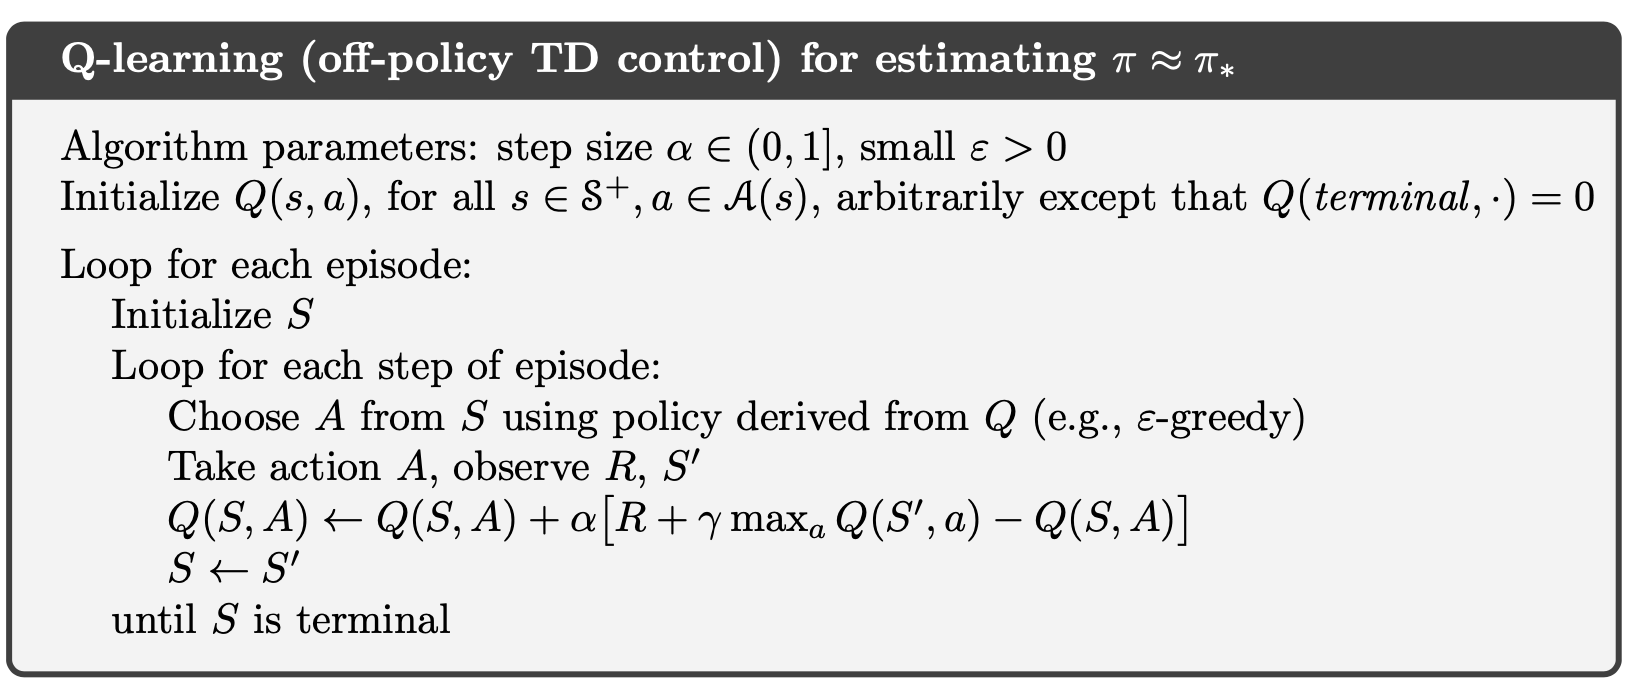

## Interface

Choose starting points from user

In [6]:
#Currently the model only works by inputting coordinates.
#These MUST be coordinates in the graph

#Only here should coordinates be (lat,lon)
s = (44.2249349,-76.4905204)

t = (44.2245047,-76.4937009)


In [7]:
def Interface(start: tuple, terminal: tuple, alpha=0.2,gamma=0.5,e=0.8, max_steps=5000, max_eps=100):
  max_eps2 = max_eps
  max_steps2 = max_steps
  alpha2 = alpha
  gamma2 = gamma
  e2 = e
  world = CWorld(G,start,terminal)

  print("Bulding the Table")
  agent = Q_learning(world, alpha=alpha2, gamma=gamma2, e=e2, max_steps=max_steps2,max_eps=max_eps2)
  print(agent.q)
  
  print("Training the agent")
  agent.train()
  print("Finished training the agent")
  
  return agent

Must fix reward formula

In [8]:
agent1 = Interface((s[1], s[0]), (t[1],t[0]),alpha=0.3,gamma=0.9,e=0.8, max_steps=20000, max_eps=100)

Bulding the Table
{(-76.4905204, 44.2249349): {(-76.4906166, 44.2249251): 10, (-76.4904534, 44.2249392): 10, (-76.4905212, 44.2249437): 10, (-76.4905148, 44.2248758): 10}, (-76.4906166, 44.2249251): {(-76.4905204, 44.2249349): 10, (-76.4908169, 44.2249044): 10, (-76.4906304, 44.2250021): 10, (-76.4906052, 44.2248614): 10}, (-76.4908169, 44.2249044): {(-76.4906166, 44.2249251): 10, (-76.4910503, 44.2248791): 10}, (-76.4910503, 44.2248791): {(-76.4908169, 44.2249044): 10, (-76.4916043, 44.2247953): 10, (-76.4910369, 44.2248081): 10}, (-76.4916043, 44.2247953): {(-76.4910503, 44.2248791): 10, (-76.4920893, 44.2247281): 10, (-76.49161, 44.2248575): 10}, (-76.4920893, 44.2247281): {(-76.4916043, 44.2247953): 10, (-76.4925185, 44.2246686): 10, (-76.492046, 44.2246693): 10, (-76.4921255, 44.2247811): 10}, (-76.4925185, 44.2246686): {(-76.4920893, 44.2247281): 10, (-76.4933756, 44.2245498): 10}, (-76.4933756, 44.2245498): {(-76.4925185, 44.2246686): 10, (-76.4937009, 44.2245047): 10, (-76.4933

KeyboardInterrupt: ignored

In [ ]:
print(agent1.q)

In [ ]:
from matplotlib.pyplot import figure

plt.plot(agent1.steps_array_stats, agent1.episodes_array_stats,"r",label="1") # Redline

plt.title("Agent Performance")
plt.ylabel("# of Episodes")
plt.xlabel("# of Time Steps")
plt.rcParams["figure.figsize"] = (10,15)
plt.show

## Map View of route


In [10]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

In [11]:
#Define coordinates of where we want to center our map
campus_coords = [44.2265204, -76.4959298]

#Create the map
my_map = folium.Map(location = campus_coords, zoom_start = 16)

#Create markers
start_coords = [s[0],s[1]]
terminal_coords = [t[0],t[1]]
#print (start_coords)

print(start_coords)

folium.Marker(start_coords, popup = 'Start').add_to(my_map)
folium.Marker(terminal_coords, popup = 'End').add_to(my_map)

#Display the map
my_map

#Whats left to display a route
# Generate a list of way ids in our code
# Create .gpx of coordinates from policy
# use folium to display the .gpx route

[44.2249349, -76.4905204]
